# Assignment8

You are to compete in the Real or Not:  NLP with Disaster Tweets competition on Kaggle.com.  https://www.kaggle.com/c/nlp-getting-started/notebooks

# Assignment Requirements

    Install the Python chakin package
    Obtain GloVe (and perhaps non-GloVe) embeddings.

    Load and run jump-start code for the assignment, which uses pretrained word vectors from GloVe.6B.50d, a vocabulary of 10,000 words, and movie review data.
    Revise the jump-start code to accommodate two pretrained word vectors and two vocabulary sizes. These represent the cells of a completely crossed 2-by-2 experimental design, defining four distinct language models.


    (Optional) Test two or more alternative RNN structures or hyperparameter settings.
    Build and evaluate at least four language models of the experimental design. For each cell in the design, compute classification accuracy in the test set.
    Evaluate the four language models and make recommendations to management.

# Management Problem
Suppose management is thinking about using a language model to classify written customer reviews and call and complaint logs. If the most critical customer messages can be identified, then customer support personnel can be assigned to contact those customers.

How would you advise senior management? What kinds of systems and methods would be most relevant to the customer services function? Considering the results of this assignment in particular, what is needed to make an automated customer support system that is capable of identifying negative customer feelings? What can data scientists do to make language models more useful in a customer service function?

    1) A summary and problem definition for management; 
    2) Discussion of the research design, measurement and statistical methods, traditional and machine learning methods employed 
    3) Overview of programming work; 
    4) Review of results with recommendations for management.

# Discussion

It's likely that considerable work has been taken by the party who collected this twitter data. In terms of relative frequency the number of natural disasters that occur are much much less frequency than the number of tweets for non natural disasters. This is also likely to be the case for our customer complaint logs. Some customers have genuinely been under served but they occur at a much lower frequency (particulary in instances of extreme diservice) than the typical complaint. Additionaly some complaints are likely fictional in nature. Additionaly, a considerable amount of preprocessing is required to convert the complaints (in the case of this dataset the tweets) into a form which is conducive to machine learning.  Namely:

    1)The data must be pulled into our memory
    2)Words which occur frequently must be removed ('stopwords' such as the, is, an, am, etc.)
    3)Punctuation should also be removed (we want to aggregate 'terrible.', 'terrible' and 'terrible,')
    4)The vocabulary of the message should be truncated or paddeded such that the dimensions of our input data is constant
    5)word vectors should be constructed.
    6)Finaly, predictions can be made.

This is a complex set of operations which require time. Aditionaly these techniques must be used on all of our background data such that we can train a model. Training a model will allow us to identify which particular customer complaints (in the example below disaster tweets)are the most crucial to address. Each problem will likely require a differnet approach and achieve a different optimal solution. It is highly likely that an optimal solution was not achieved below with our disaster tweet dataset. Of the parameters studied below (which are non comprehensive of the entire classfication space) vocabulary size seemed to have a much larger impact for the Glove.6B embedding over the Glove.twitter embedding (both of which had 50 dimensions).  Two vocabulary sizes were stuided 1000 and 800 words for the input tweet data. Two separate embeddings as previously mentioned were utilized. After removing the stopwords from our input data the Glove.6B embedding seemed to outperfrom the Glove.twitter embedding slightly, however both performed fairly well with no human imput following the intitial construction of the pipelines which feed data into the model. It's therefore recommended that evalution of the customer complaint system should take place including exploration of vocabulary size, embedding source, and various model structures (hyperparameters and layers; which were not addressed in this particular study) such that we can flag those complaints which require more rigourous human interaction and followup. 

In [1]:
# Common imports for our work
import os 
import numpy as np
import tensorflow as tf
import time
import pandas as pd  # data frame operations  
import numpy as np  # arrays and math functions
import matplotlib.pyplot as plt  # static plotting
import re # regular expressions

import scipy
import os # Operation System
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib.backends.backend_pdf import PdfPages
import sklearn
import tensorflow as tf
from datetime import datetime
#from __future__ import division, print_function, unicode_literals
import cv2
import seaborn as sns
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from nltk.corpus import stopwords


# Python chakin package previously installed by 
#    pip install chakin
import chakin  

import json
import os
from collections import defaultdict

RANDOM_SEED = 9999

In [2]:
#chakin.search(lang='English')  # lists available indices in English

In [3]:
#### Specify English embeddings file to download and install by index number, number of dimensions, and subfoder name
#### Note that GloVe 50-, 100-, 200-, and 300-dimensional folders are downloaded with a single zip download
#CHAKIN_INDEX = 11
#NUMBER_OF_DIMENSIONS = 50
#SUBFOLDER_NAME = "gloVe.6B"

In [4]:
#DATA_FOLDER = "embeddings"
#ZIP_FILE = os.path.join(DATA_FOLDER, "{}.zip".format(SUBFOLDER_NAME))
#ZIP_FILE_ALT = "glove" + ZIP_FILE[5:]  # sometimes it's lowercase only...
#UNZIP_FOLDER = os.path.join(DATA_FOLDER, SUBFOLDER_NAME)
#if SUBFOLDER_NAME[-1] == "d":
#    GLOVE_FILENAME = os.path.join(
#        UNZIP_FOLDER, "{}.txt".format(SUBFOLDER_NAME))
#else:
#    GLOVE_FILENAME = os.path.join(UNZIP_FOLDER, "{}.{}d.txt".format(
#        SUBFOLDER_NAME, NUMBER_OF_DIMENSIONS))


#if not os.path.exists(ZIP_FILE) and not os.path.exists(UNZIP_FOLDER):
    ### GloVe by Stanford is licensed Apache 2.0:
    ###     https://github.com/stanfordnlp/GloVe/blob/master/LICENSE
    ###     http://nlp.stanford.edu/data/glove.twitter.27B.zip
    ###    Copyright 2014 The Board of Trustees of The Leland Stanford Junior University
#    print("Downloading embeddings to '{}'".format(ZIP_FILE))
#    chakin.download(number=CHAKIN_INDEX, save_dir='./{}'.format(DATA_FOLDER))
#else:
#    print("Embeddings already downloaded.")

#if not os.path.exists(UNZIP_FOLDER):
#    import zipfile
#    if not os.path.exists(ZIP_FILE) and os.path.exists(ZIP_FILE_ALT):
#        ZIP_FILE = ZIP_FILE_ALT
#    with zipfile.ZipFile(ZIP_FILE, "r") as zip_ref:
#        print("Extracting embeddings to '{}'".format(UNZIP_FOLDER))
#        zip_ref.extractall(UNZIP_FOLDER)
#else:
#    print("Embeddings already extracted.")

#print('\nRun complete')

##### After this step there should be
##### embeddings folder in the current working directory A
##### Directory called glove.6b within embeddings directory
##### 4 files within it

# Data Preparation:
     1)read-in data
     2)remove stopwords
     3)keep alphanumerics
     4)get label counts and plot
     5)train validation split

In [5]:
train_data = pd.read_csv("C:/Users/bblank/Documents/Northwestern MSDS/datasets/week 8 - Kaggle Disaster Tweets/nlp-getting-started/train.csv")

In [6]:
data2 = train_data[['text', 'target']]
print(data2.head)
stop = stopwords.words('english')

data2.text = data2.text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
print(data2.head)

<bound method NDFrame.head of                                                    text  target
0     Our Deeds are the Reason of this #earthquake M...       1
1                Forest fire near La Ronge Sask. Canada       1
2     All residents asked to 'shelter in place' are ...       1
3     13,000 people receive #wildfires evacuation or...       1
4     Just got sent this photo from Ruby #Alaska as ...       1
...                                                 ...     ...
7608  Two giant cranes holding a bridge collapse int...       1
7609  @aria_ahrary @TheTawniest The out of control w...       1
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1
7611  Police investigating after an e-bike collided ...       1
7612  The Latest: More Homes Razed by Northern Calif...       1

[7613 rows x 2 columns]>
<bound method NDFrame.head of                                                    text  target
0     Our Deeds Reason #earthquake May ALLAH Forgive us       1
1                F

In [7]:
stop[:5]

['i', 'me', 'my', 'myself', 'we']

In [8]:


labels = np.asarray(data2.target)

observations =np.array([['Nondisasters', len(labels[labels==0])], ['Disasters',len(labels[labels==1])]])
df = pd.DataFrame(data= observations, columns=["Observations", "Counts"])
df.head()

,Observations,Counts
0,Nondisasters,4342
1,Disasters,3271


<AxesSubplot:xlabel='Observations', ylabel='Counts'>

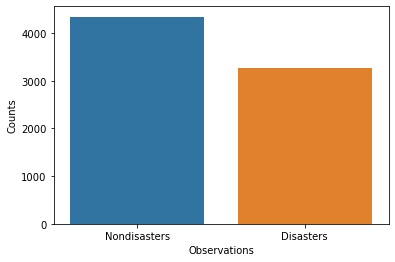

In [9]:

sns.barplot(x= df.Observations, y =df.Counts.astype('int32'))

In [10]:
data2.text.dtype

dtype('O')

In [11]:
data2.text = data2.text.str.replace('[^a-zA-Z]', ' ')

ipykernel_launcher:1: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\bblank\Anaconda3\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [12]:
data2.text[:5]

0    Our Deeds Reason  earthquake May ALLAH Forgive us
1               Forest fire near La Ronge Sask  Canada
2    All residents asked  shelter place  notified o...
3           people receive  wildfires evacuation or...
4    Just got sent photo Ruby  Alaska smoke  wildfi...
Name: text, dtype: object

In [13]:
samples = data2.text
labels = data2.target

rng = np.random.RandomState(RANDOM_SEED)
rng.shuffle(samples)
rng = np.random.RandomState(RANDOM_SEED)
rng.shuffle(labels)

# Extract a training & validation split
validation_split = 0.2
num_validation_samples = int(validation_split * len(samples))
x_train = samples[:-num_validation_samples]
x_val = samples[-num_validation_samples:]
y_train = labels[:-num_validation_samples]
y_val = labels[-num_validation_samples:]

ipykernel_launcher:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\bblank\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3427: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
ipykernel_launcher:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
print('The proportion of disaster tweets in train is:', round(np.mean(y_train),3))
print('The proportion of disaster tweets in test is:', round(np.mean(y_val),3))

The proportion of disaster tweets in train is: 0.425
The proportion of disaster tweets in test is: 0.447


# Experiment V1000_Glove.6B

In [15]:
MAX_NB_WORDS = 1000
MAX_SEQUENCE_LENGTH = 150


vectorizer = TextVectorization(max_tokens=MAX_NB_WORDS, output_sequence_length=MAX_SEQUENCE_LENGTH)
text_ds = tf.data.Dataset.from_tensor_slices(x_train).batch(128)
vectorizer.adapt(text_ds)


voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

print('Selected %s unique tokens.' % len(word_index))

Selected 1000 unique tokens.


## Build Imbedding Matrix V1000_Glove.6B

In [16]:
GLOVE_DIR = 'C:/Users/bblank/Documents/Northwestern MSDS/datasets/embeddings/'

hits = 0
misses = 0

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.50d.txt'), encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

EMBEDDING_DIM = 50

embedding_matrix = np.zeros((len(word_index) + 2, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

print('Converted %d words (%d misses)' %(hits, misses))

Found 400000 word vectors.
Converted 993 words (7 misses)


In [17]:
x_train = vectorizer(np.array([[s] for s in x_train])).numpy()
x_val = vectorizer(np.array([[s] for s in x_val])).numpy()

y_train = np.array(y_train)
y_val = np.array(y_val)

## Build, compile and train model (V1000_Glove.6B)

In [18]:
e = Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False, mask_zero=True)
opt = keras.optimizers.Adam(learning_rate=0.01)

GRU_model =keras.models.Sequential()
GRU_model.add(e)
GRU_model.add(keras.layers.GRU(128, return_sequences=True))

GRU_model.add(keras.layers.Flatten())
GRU_model.add(keras.layers.Dense(1, activation='sigmoid'))
# compile the model
GRU_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])


In [19]:
before_fit = datetime.now()
V1000_Glove_6B = GRU_model.fit(x_train, y_train, epochs=20)

after_fit = datetime.now()
elapsed =after_fit - before_fit
V1000_Glove_6B_duration = elapsed.total_seconds()



Epoch 1/20
191/191 [==============================] - 15s 66ms/step - loss: 1.2751 - accuracy: 0.6534
Epoch 2/20
191/191 [==============================] - 13s 68ms/step - loss: 0.5846 - accuracy: 0.7437
Epoch 3/20
191/191 [==============================] - 13s 68ms/step - loss: 0.5075 - accuracy: 0.7740
Epoch 4/20
191/191 [==============================] - 13s 67ms/step - loss: 0.4912 - accuracy: 0.7841
Epoch 5/20
191/191 [==============================] - 13s 67ms/step - loss: 0.4878 - accuracy: 0.7915
Epoch 6/20
191/191 [==============================] - 13s 66ms/step - loss: 0.4547 - accuracy: 0.8028
Epoch 7/20
191/191 [==============================] - 13s 67ms/step - loss: 0.4315 - accuracy: 0.8108
Epoch 8/20
191/191 [==============================] - 13s 66ms/step - loss: 0.4351 - accuracy: 0.8113
Epoch 9/20
191/191 [==============================] - 13s 67ms/step - loss: 0.4603 - accuracy: 0.8043
Epoch 10/20
191/191 [==============================] - 13s 67ms/step - loss: 0.452

In [20]:
# evaluate the model
V1000_Glove_6B_loss, V1000_Glove_6B_accuracy =GRU_model.evaluate(x_val, y_val, verbose=0)
print('Accuracy: %f' % (V1000_Glove_6B_accuracy*100))
print('Loss: %f' %(V1000_Glove_6B_loss))

Accuracy: 75.164258
Loss: 0.574470


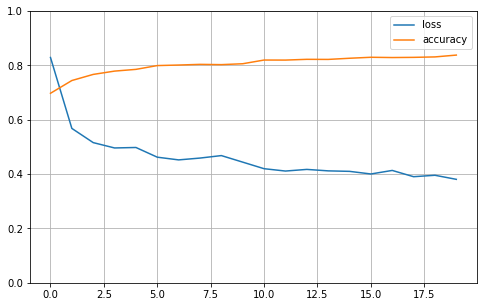

In [21]:
pd.DataFrame(V1000_Glove_6B .history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

## Kaggle Test data
    1) Data read in and cleaning
    2) Build it's embedding matrix.
    3) Make predictions
    4) write dataframe out

In [22]:
KaggleTest = pd.read_csv("C:/Users/bblank/Documents/Northwestern MSDS/datasets/week 8 - Kaggle Disaster Tweets/nlp-getting-started/test.csv")
data2 = KaggleTest[['text', 'id']]
print(data2.head)
stop = stopwords.words('english')

data2.text = data2.text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
print(data2.head)

data2.text = data2.text.str.replace('[^a-zA-Z]', ' ')

X_kaggleTest= vectorizer(np.array([[s] for s in data2.text])).numpy()

preds = GRU_model.predict_classes(X_kaggleTest)
preds = preds.tolist()
preds = [item for sublist in preds for item in sublist]

data_submit = {'id':data2.id, 
        'target': preds} 
# Create DataFrame 
df_submit = pd.DataFrame(data_submit)
df_submit.to_csv('V1000_Glove_6B.csv',index=False)


<bound method NDFrame.head of                                                    text     id
0                    Just happened a terrible car crash      0
1     Heard about #earthquake is different cities, s...      2
2     there is a forest fire at spot pond, geese are...      3
3              Apocalypse lighting. #Spokane #wildfires      9
4         Typhoon Soudelor kills 28 in China and Taiwan     11
...                                                 ...    ...
3258  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...  10861
3259  Storm in RI worse than last hurricane. My city...  10865
3260  Green Line derailment in Chicago http://t.co/U...  10868
3261  MEG issues Hazardous Weather Outlook (HWO) htt...  10874
3262  #CityofCalgary has activated its Municipal Eme...  10875

[3263 rows x 2 columns]>
<bound method NDFrame.head of                                                    text     id
0                      Just happened terrible car crash      0
1     Heard #earthquake differen

## Experiment V1000_Glove.6B Summary

In [23]:
V1000_Glove_6B_Summary = {
    'Experiment': ['V1000_Glove.6B'], 
    'Embedding': ['Glove.6B_50d'],
    'MissedVocab(%)': [misses/MAX_NB_WORDS*100], 
    'TrainDuration(s)': [V1000_Glove_6B_duration],
    'Accuracy': [V1000_Glove_6B_accuracy],
    'KaggleScore': [0.7706]
    
        }

V1000_Glove_6B_Summary_df = pd.DataFrame.from_dict(V1000_Glove_6B_Summary)
display(V1000_Glove_6B_Summary_df)

,Experiment,Embedding,MissedVocab(%),TrainDuration(s),Accuracy,KaggleScore
0,V1000_Glove.6B,Glove.6B_50d,0.7,260.997262,0.751643,0.7706


# Experiment V800_Glove.6B

In [24]:
data2 = train_data[['text', 'target']]

samples = data2.text
labels = data2.target

rng = np.random.RandomState(RANDOM_SEED)
rng.shuffle(samples)
rng = np.random.RandomState(RANDOM_SEED)
rng.shuffle(labels)

# Extract a training & validation split
validation_split = 0.2
num_validation_samples = int(validation_split * len(samples))
x_train = samples[:-num_validation_samples]
x_val = samples[-num_validation_samples:]
y_train = labels[:-num_validation_samples]
y_val = labels[-num_validation_samples:]

ipykernel_launcher:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\bblank\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3427: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
ipykernel_launcher:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [25]:
MAX_NB_WORDS = 800
MAX_SEQUENCE_LENGTH = 150


vectorizer = TextVectorization(max_tokens=MAX_NB_WORDS, output_sequence_length=MAX_SEQUENCE_LENGTH)
text_ds = tf.data.Dataset.from_tensor_slices(x_train).batch(128)
vectorizer.adapt(text_ds)


voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

print('Selected %s unique tokens.' % len(word_index))

Selected 800 unique tokens.


## Build Embedding Matrix V800_Glove.6B

In [26]:
GLOVE_DIR = 'C:/Users/bblank/Documents/Northwestern MSDS/datasets/embeddings/'

hits = 0
misses = 0

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.50d.txt'), encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

EMBEDDING_DIM = 50

embedding_matrix = np.zeros((len(word_index) + 2, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

print('Converted %d words (%d misses)' %(hits, misses))

Found 400000 word vectors.
Converted 788 words (12 misses)


In [27]:
x_train = vectorizer(np.array([[s] for s in x_train])).numpy()
x_val = vectorizer(np.array([[s] for s in x_val])).numpy()

y_train = np.array(y_train)
y_val = np.array(y_val)

## Build, Compile, Train model (V800_Glove.6B)

In [28]:
e = Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False, mask_zero=True)
opt = keras.optimizers.Adam(learning_rate=0.01)

GRU_model =keras.models.Sequential()
GRU_model.add(e)
GRU_model.add(keras.layers.GRU(128, return_sequences=True))

GRU_model.add(keras.layers.Flatten())
GRU_model.add(keras.layers.Dense(1, activation='sigmoid'))
# compile the model
GRU_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
before_fit = datetime.now()
V800_Glove_6B = GRU_model.fit(x_train, y_train, epochs=20)

after_fit = datetime.now()
elapsed =after_fit - before_fit
V800_Glove_6B_duration = elapsed.total_seconds()


Epoch 1/20
191/191 [==============================] - 15s 67ms/step - loss: 1.1576 - accuracy: 0.6468
Epoch 2/20
191/191 [==============================] - 13s 68ms/step - loss: 0.6003 - accuracy: 0.7387
Epoch 3/20
191/191 [==============================] - 13s 68ms/step - loss: 0.5337 - accuracy: 0.7640
Epoch 4/20
191/191 [==============================] - 13s 69ms/step - loss: 0.5027 - accuracy: 0.7799
Epoch 5/20
191/191 [==============================] - 13s 68ms/step - loss: 0.4632 - accuracy: 0.7925
Epoch 6/20
191/191 [==============================] - 13s 68ms/step - loss: 0.4816 - accuracy: 0.7805
Epoch 7/20
191/191 [==============================] - 13s 68ms/step - loss: 0.4558 - accuracy: 0.7984
Epoch 8/20
191/191 [==============================] - 13s 68ms/step - loss: 0.4370 - accuracy: 0.8094
Epoch 9/20
191/191 [==============================] - 13s 68ms/step - loss: 0.4278 - accuracy: 0.8206
Epoch 10/20
191/191 [==============================] - 13s 68ms/step - loss: 0.442

In [30]:
V800_Glove_6B_loss, V800_Glove_6B_accuracy =GRU_model.evaluate(x_val, y_val, verbose=0)
print('Accuracy: %f' % (V800_Glove_6B_accuracy*100))
print('Loss: %f' %(V800_Glove_6B_loss))

Accuracy: 76.215506
Loss: 0.595173


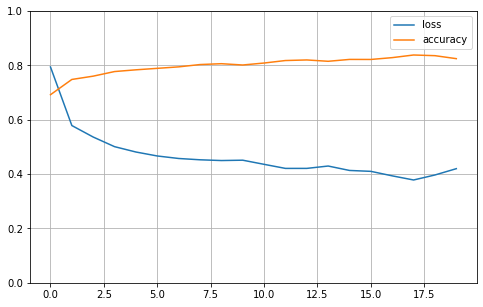

In [31]:
pd.DataFrame(V800_Glove_6B .history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

## Kaggle

In [32]:
KaggleTest = pd.read_csv("C:/Users/bblank/Documents/Northwestern MSDS/datasets/week 8 - Kaggle Disaster Tweets/nlp-getting-started/test.csv")
data2 = KaggleTest[['text', 'id']]
print(data2.head)
stop = stopwords.words('english')

data2.text = data2.text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
print(data2.head)

data2.text = data2.text.str.replace('[^a-zA-Z]', ' ')

X_kaggleTest= vectorizer(np.array([[s] for s in data2.text])).numpy()

preds = GRU_model.predict_classes(X_kaggleTest)
preds = preds.tolist()
preds = [item for sublist in preds for item in sublist]

data_submit = {'id':data2.id, 
        'target': preds} 
# Create DataFrame 
df_submit = pd.DataFrame(data_submit)
df_submit.to_csv('V800_Glove_6B.csv',index=False)


<bound method NDFrame.head of                                                    text     id
0                    Just happened a terrible car crash      0
1     Heard about #earthquake is different cities, s...      2
2     there is a forest fire at spot pond, geese are...      3
3              Apocalypse lighting. #Spokane #wildfires      9
4         Typhoon Soudelor kills 28 in China and Taiwan     11
...                                                 ...    ...
3258  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...  10861
3259  Storm in RI worse than last hurricane. My city...  10865
3260  Green Line derailment in Chicago http://t.co/U...  10868
3261  MEG issues Hazardous Weather Outlook (HWO) htt...  10874
3262  #CityofCalgary has activated its Municipal Eme...  10875

[3263 rows x 2 columns]>
<bound method NDFrame.head of                                                    text     id
0                      Just happened terrible car crash      0
1     Heard #earthquake differen

## Summary V800_Glove.6B


In [33]:
V800_Glove_6B_Summary = {
    'Experiment': ['V800_Glove.6B'], 
    'Embedding': ['Glove.6B_50d'],
    'MissedVocab(%)': [misses/MAX_NB_WORDS*100], 
    'TrainDuration(s)': [V800_Glove_6B_duration],
    'Accuracy': [V800_Glove_6B_accuracy],
    'KaggleScore': [0.71498]
    
        }

V800_Glove_6B_Summary_df = pd.DataFrame.from_dict(V800_Glove_6B_Summary)
display(V800_Glove_6B_Summary_df)

,Experiment,Embedding,MissedVocab(%),TrainDuration(s),Accuracy,KaggleScore
0,V800_Glove.6B,Glove.6B_50d,1.5,266.501191,0.762155,0.71498


# Experiment V1000_Glove.Twitter

## Preprocesses data (Train/Test split, Vectorization, and Embedding matrix construction) for V1000_Glove.Twitter

In [34]:
#re-establishes a fresh training set
data2 = train_data[['text', 'target']]

samples = data2.text
labels = data2.target

rng = np.random.RandomState(RANDOM_SEED)
rng.shuffle(samples)
rng = np.random.RandomState(RANDOM_SEED)
rng.shuffle(labels)

# Extract a training & validation split
validation_split = 0.2
num_validation_samples = int(validation_split * len(samples))
x_train = samples[:-num_validation_samples]
x_val = samples[-num_validation_samples:]
y_train = labels[:-num_validation_samples]
y_val = labels[-num_validation_samples:]
### ---------------------------------------------###
#Fixed vocabulary length and tweet length (NB_Words and SEQWUENCE_LENGTH)
MAX_NB_WORDS = 1000
MAX_SEQUENCE_LENGTH = 150
### ---------------------------------------------###

#TextVectorization (cleans, and tokenizes, truncates and pads sequences)
vectorizer = TextVectorization(max_tokens=MAX_NB_WORDS, output_sequence_length=MAX_SEQUENCE_LENGTH)
text_ds = tf.data.Dataset.from_tensor_slices(x_train).batch(128)
vectorizer.adapt(text_ds)


voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

print('Selected %s unique tokens.' % len(word_index))

#loads embeddings
GLOVE_DIR = 'C:/Users/bblank/Documents/Northwestern MSDS/datasets/embeddings/'

hits = 0
misses = 0

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.twitter.27B.50d.txt'), encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

#Builds the embedding matrix
EMBEDDING_DIM = 50

embedding_matrix = np.zeros((len(word_index) + 2, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

print('Converted %d words (%d misses)' %(hits, misses))

# Applies vectorizer to each X; returning a numpy array
x_train = vectorizer(np.array([[s] for s in x_train])).numpy()
x_val = vectorizer(np.array([[s] for s in x_val])).numpy()

y_train = np.array(y_train)
y_val = np.array(y_val)

ipykernel_launcher:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\bblank\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3427: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
ipykernel_launcher:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Selected 1000 unique tokens.
Found 1193514 word vectors.
Converted 960 words (40 misses)


## Model construction, training, performance V1000_Glove.Twitter

Epoch 1/20
191/191 [==============================] - 15s 64ms/step - loss: 1.1509 - accuracy: 0.6789
Epoch 2/20
191/191 [==============================] - 13s 69ms/step - loss: 0.5453 - accuracy: 0.7593
Epoch 3/20
191/191 [==============================] - 14s 72ms/step - loss: 0.5068 - accuracy: 0.7742
Epoch 4/20
191/191 [==============================] - 13s 70ms/step - loss: 0.4656 - accuracy: 0.7916
Epoch 5/20
191/191 [==============================] - 13s 69ms/step - loss: 0.4451 - accuracy: 0.8050
Epoch 6/20
191/191 [==============================] - 13s 69ms/step - loss: 0.4341 - accuracy: 0.8047
Epoch 7/20
191/191 [==============================] - 13s 69ms/step - loss: 0.4396 - accuracy: 0.8049
Epoch 8/20
191/191 [==============================] - 13s 69ms/step - loss: 0.4228 - accuracy: 0.8112
Epoch 9/20
191/191 [==============================] - 13s 70ms/step - loss: 0.3960 - accuracy: 0.8221
Epoch 10/20
191/191 [==============================] - 13s 70ms/step - loss: 0.413

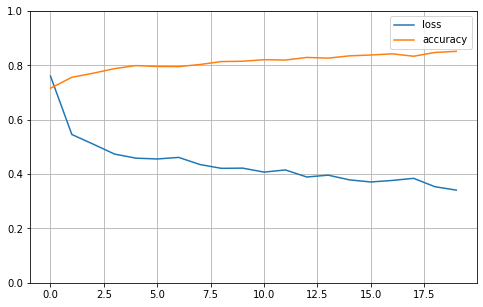

In [35]:
e = Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False, mask_zero=True)
opt = keras.optimizers.Adam(learning_rate=0.01)

GRU_model =keras.models.Sequential()
GRU_model.add(e)
GRU_model.add(keras.layers.GRU(128, return_sequences=True))

GRU_model.add(keras.layers.Flatten())
GRU_model.add(keras.layers.Dense(1, activation='sigmoid'))
# compile the model
GRU_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

#fits model and generates elapsed duration
before_fit = datetime.now()
V1000_Glove_Twitter = GRU_model.fit(x_train, y_train, epochs=20)

after_fit = datetime.now()
elapsed =after_fit - before_fit
V1000_Glove_Twitter_duration = elapsed.total_seconds()

# Generates loss and accuracy for test set
V1000_Glove_Twitter_loss, V1000_Glove_Twitter_accuracy =GRU_model.evaluate(x_val, y_val, verbose=0)
print('Accuracy: %f' % (V1000_Glove_Twitter_accuracy*100))
print('Loss: %f' %(V1000_Glove_Twitter_loss))

#Learning Curve
pd.DataFrame(V1000_Glove_Twitter.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()


## Kaggle predictions for V1000_Glove.Twitter

In [36]:
KaggleTest = pd.read_csv("C:/Users/bblank/Documents/Northwestern MSDS/datasets/week 8 - Kaggle Disaster Tweets/nlp-getting-started/test.csv")
data2 = KaggleTest[['text', 'id']]
print(data2.head)
stop = stopwords.words('english')

data2.text = data2.text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
print(data2.head)

data2.text = data2.text.str.replace('[^a-zA-Z]', ' ')

X_kaggleTest= vectorizer(np.array([[s] for s in data2.text])).numpy()

preds = GRU_model.predict_classes(X_kaggleTest)
preds = preds.tolist()
preds = [item for sublist in preds for item in sublist]

data_submit = {'id':data2.id, 
        'target': preds} 
# Create DataFrame 
df_submit = pd.DataFrame(data_submit)
df_submit.to_csv('V1000_Glove_Twitter.csv',index=False)

<bound method NDFrame.head of                                                    text     id
0                    Just happened a terrible car crash      0
1     Heard about #earthquake is different cities, s...      2
2     there is a forest fire at spot pond, geese are...      3
3              Apocalypse lighting. #Spokane #wildfires      9
4         Typhoon Soudelor kills 28 in China and Taiwan     11
...                                                 ...    ...
3258  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...  10861
3259  Storm in RI worse than last hurricane. My city...  10865
3260  Green Line derailment in Chicago http://t.co/U...  10868
3261  MEG issues Hazardous Weather Outlook (HWO) htt...  10874
3262  #CityofCalgary has activated its Municipal Eme...  10875

[3263 rows x 2 columns]>
<bound method NDFrame.head of                                                    text     id
0                      Just happened terrible car crash      0
1     Heard #earthquake differen

## Kaggle Summary V1000_Glove.Twitter

In [37]:
V1000_Glove_Twitter_Summary = {
    'Experiment': ['V1000_Glove.Twitter'], 
    'Embedding': ['glove.twitter.27B.50d'],
    'MissedVocab(%)': [misses/MAX_NB_WORDS*100], 
    'TrainDuration(s)': [V1000_Glove_Twitter_duration],
    'Accuracy': [V1000_Glove_Twitter_accuracy],
    'KaggleScore': [0.74379]
    
        }

V1000_Glove_Twitter_Summary_df = pd.DataFrame.from_dict(V1000_Glove_Twitter_Summary)
display(V1000_Glove_Twitter_Summary_df)

,Experiment,Embedding,MissedVocab(%),TrainDuration(s),Accuracy,KaggleScore
0,V1000_Glove.Twitter,glove.twitter.27B.50d,4.0,267.578829,0.766097,0.74379


# V800_Glove_Twitter 

## Preprocesses data (Train/Test split, Vectorization, and Embedding matrix construction) for V800_Glove.Twitter

In [38]:
#re-establishes a fresh training set
data2 = train_data[['text', 'target']]

samples = data2.text
labels = data2.target

rng = np.random.RandomState(RANDOM_SEED)
rng.shuffle(samples)
rng = np.random.RandomState(RANDOM_SEED)
rng.shuffle(labels)

# Extract a training & validation split
validation_split = 0.2
num_validation_samples = int(validation_split * len(samples))
x_train = samples[:-num_validation_samples]
x_val = samples[-num_validation_samples:]
y_train = labels[:-num_validation_samples]
y_val = labels[-num_validation_samples:]
### ---------------------------------------------###
#Fixed vocabulary length and tweet length (NB_Words and SEQWUENCE_LENGTH)
MAX_NB_WORDS = 800
MAX_SEQUENCE_LENGTH = 150
### ---------------------------------------------###

#TextVectorization (cleans, and tokenizes, truncates and pads sequences)
vectorizer = TextVectorization(max_tokens=MAX_NB_WORDS, output_sequence_length=MAX_SEQUENCE_LENGTH)
text_ds = tf.data.Dataset.from_tensor_slices(x_train).batch(128)
vectorizer.adapt(text_ds)


voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

print('Selected %s unique tokens.' % len(word_index))

#loads embeddings
GLOVE_DIR = 'C:/Users/bblank/Documents/Northwestern MSDS/datasets/embeddings/'

hits = 0
misses = 0

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.twitter.27B.50d.txt'), encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

#Builds the embedding matrix
EMBEDDING_DIM = 50

embedding_matrix = np.zeros((len(word_index) + 2, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

print('Converted %d words (%d misses)' %(hits, misses))

# Applies vectorizer to each X; returning a numpy array
x_train = vectorizer(np.array([[s] for s in x_train])).numpy()
x_val = vectorizer(np.array([[s] for s in x_val])).numpy()

y_train = np.array(y_train)
y_val = np.array(y_val)

ipykernel_launcher:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\bblank\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3427: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
ipykernel_launcher:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Selected 800 unique tokens.
Found 1193514 word vectors.
Converted 769 words (31 misses)


## Model construction, training, performance V800_Glove.Twitter

Epoch 1/20
191/191 [==============================] - 15s 68ms/step - loss: 1.0842 - accuracy: 0.6542
Epoch 2/20
191/191 [==============================] - 14s 75ms/step - loss: 0.5433 - accuracy: 0.7508
Epoch 3/20
191/191 [==============================] - 15s 78ms/step - loss: 0.5093 - accuracy: 0.7731
Epoch 4/20
191/191 [==============================] - 14s 74ms/step - loss: 0.4993 - accuracy: 0.7715
Epoch 5/20
191/191 [==============================] - 14s 73ms/step - loss: 0.4745 - accuracy: 0.7796
Epoch 6/20
191/191 [==============================] - 14s 73ms/step - loss: 0.4556 - accuracy: 0.7878
Epoch 7/20
191/191 [==============================] - 14s 73ms/step - loss: 0.4596 - accuracy: 0.7873
Epoch 8/20
191/191 [==============================] - 14s 72ms/step - loss: 0.4168 - accuracy: 0.8090
Epoch 9/20
191/191 [==============================] - 14s 73ms/step - loss: 0.4525 - accuracy: 0.8048
Epoch 10/20
191/191 [==============================] - 14s 73ms/step - loss: 0.408

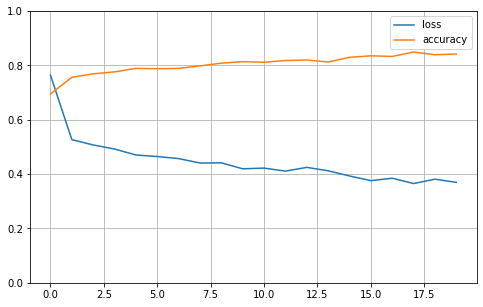

In [39]:
e = Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False, mask_zero=True)
opt = keras.optimizers.Adam(learning_rate=0.01)

GRU_model =keras.models.Sequential()
GRU_model.add(e)
GRU_model.add(keras.layers.GRU(128, return_sequences=True))

GRU_model.add(keras.layers.Flatten())
GRU_model.add(keras.layers.Dense(1, activation='sigmoid'))
# compile the model
GRU_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

#fits model and generates elapsed duration
before_fit = datetime.now()
V800_Glove_Twitter = GRU_model.fit(x_train, y_train, epochs=20)

after_fit = datetime.now()
elapsed =after_fit - before_fit
V800_Glove_Twitter_duration = elapsed.total_seconds()

# Generates loss and accuracy for test set
V800_Glove_Twitter_loss, V800_Glove_Twitter_accuracy =GRU_model.evaluate(x_val, y_val, verbose=0)
print('Accuracy: %f' % (V800_Glove_Twitter_accuracy*100))
print('Loss: %f' %(V800_Glove_Twitter_loss))

#Learning Curve
pd.DataFrame(V800_Glove_Twitter.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

## Kaggle predictions for V1000_Glove.Twitter

In [40]:
KaggleTest = pd.read_csv("C:/Users/bblank/Documents/Northwestern MSDS/datasets/week 8 - Kaggle Disaster Tweets/nlp-getting-started/test.csv")
data2 = KaggleTest[['text', 'id']]
print(data2.head)
stop = stopwords.words('english')

data2.text = data2.text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
print(data2.head)

data2.text = data2.text.str.replace('[^a-zA-Z]', ' ')

X_kaggleTest= vectorizer(np.array([[s] for s in data2.text])).numpy()

preds = GRU_model.predict_classes(X_kaggleTest)
preds = preds.tolist()
preds = [item for sublist in preds for item in sublist]

data_submit = {'id':data2.id, 
        'target': preds} 
# Create DataFrame 
df_submit = pd.DataFrame(data_submit)
df_submit.to_csv('V800_Glove_Twitter.csv',index=False)

<bound method NDFrame.head of                                                    text     id
0                    Just happened a terrible car crash      0
1     Heard about #earthquake is different cities, s...      2
2     there is a forest fire at spot pond, geese are...      3
3              Apocalypse lighting. #Spokane #wildfires      9
4         Typhoon Soudelor kills 28 in China and Taiwan     11
...                                                 ...    ...
3258  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...  10861
3259  Storm in RI worse than last hurricane. My city...  10865
3260  Green Line derailment in Chicago http://t.co/U...  10868
3261  MEG issues Hazardous Weather Outlook (HWO) htt...  10874
3262  #CityofCalgary has activated its Municipal Eme...  10875

[3263 rows x 2 columns]>
<bound method NDFrame.head of                                                    text     id
0                      Just happened terrible car crash      0
1     Heard #earthquake differen

In [41]:
V800_Glove_Twitter_Summary = {
    'Experiment': ['V800_Glove.Twitter'], 
    'Embedding': ['glove.twitter.27B.50d'],
    'MissedVocab(%)': [misses/MAX_NB_WORDS*100], 
    'TrainDuration(s)': [V800_Glove_Twitter_duration],
    'Accuracy': [V800_Glove_Twitter_accuracy],
    'KaggleScore': [0.73980]
    
        }

V800_Glove_Twitter_Summary_df = pd.DataFrame.from_dict(V800_Glove_Twitter_Summary)
display(V800_Glove_Twitter_Summary_df)

,Experiment,Embedding,MissedVocab(%),TrainDuration(s),Accuracy,KaggleScore
0,V800_Glove.Twitter,glove.twitter.27B.50d,3.875,284.496802,0.751643,0.7398


In [42]:
#### Summary Table
print('------------------------------- Summary Table -------------------------------')
list_df = [V1000_Glove_6B_Summary_df, V1000_Glove_Twitter_Summary_df , V800_Glove_6B_Summary_df, V800_Glove_Twitter_Summary_df]
summary_df = pd.concat(list_df)

display(summary_df)

------------------------------- Summary Table -------------------------------


,Experiment,Embedding,MissedVocab(%),TrainDuration(s),Accuracy,KaggleScore
0,V1000_Glove.6B,Glove.6B_50d,0.700,260.997262,0.751643,0.77060
0,V1000_Glove.Twitter,glove.twitter.27B.50d,4.000,267.578829,0.766097,0.74379
0,V800_Glove.6B,Glove.6B_50d,1.500,266.501191,0.762155,0.71498
0,V800_Glove.Twitter,glove.twitter.27B.50d,3.875,284.496802,0.751643,0.73980


Management Problem
- Suppose management is thinking about using a language model to classify written customer reviews and call and complaint logs. If the most critical customer messages can be identified, then customer support personnel can be assigned to contact those customers.
- How would you advise senior management? What kinds of systems and methods would be most relevant to the customer services function? Considering the results of this assignment in particular, what is needed to make an automated customer support system that is capable of identifying negative customer feelings? What can data scientists do to make language models more useful in a customer service function?


#### REPORT/FINDINGS: 
(1) A summary and problem definition for management; 

(2) Discussion of the research design, measurement and statistical methods, traditional and machine learning methods employed 

(3) Overview of programming work; 

(4) Review of results with recommendations for management.
